## ■ Mobile net에서 사용한 기법들 2가지

1. Depthwise Convolutional Filters
2. Pointwise Convolutional Filters

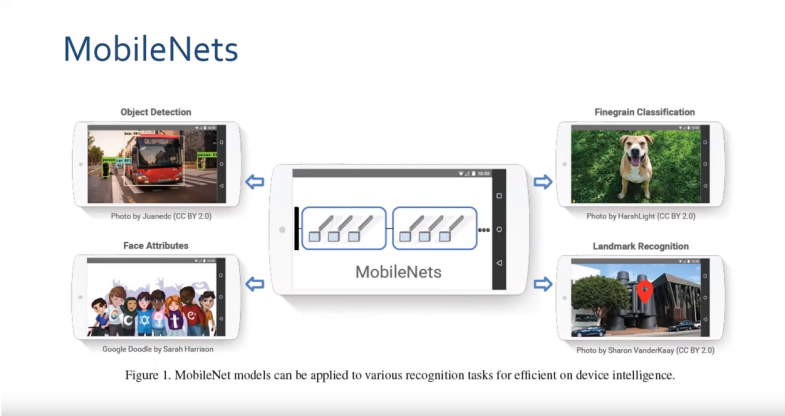

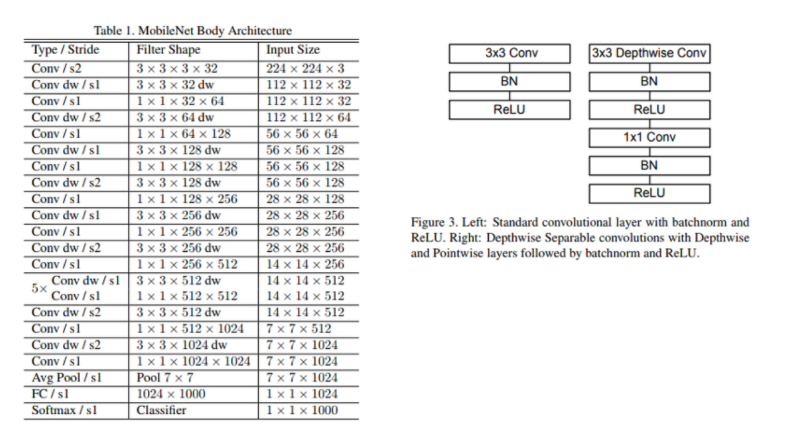

### ● Depthwise Convolution Filters

__일반 3차원 합성곱 :__

RGB 원본이미지 ◎ RGB 필터 


__Depthwise 합성곱 :__  

필터의 사이즈가 W * H * 1 이고 원본이미지가 각 Channel마다 별개로 Convolution을 한다.

### ● Pointwise Convolutional Filters

필터(커널) 사이즈가 1(width) x 1(height) x 3 (depth) 으로 설정하고 합성곱을 한다.

http://melonicedlatte.com/machinelearning/2019/11/01/212800.html

## ■ Mobile net 신경망 아키텍쳐 코드

In [ ]:
# Mobile  net  신경망 아키텍쳐 확인하는 코드

from keras import models, layers
from keras import Input
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers, initializers, regularizers, metrics
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import BatchNormalization, DepthwiseConv2D, Conv2D, Activation, Dense
from keras.layers import GlobalAveragePooling2D, ZeroPadding2D, Reshape, Dropout
 
 
 
import os
import matplotlib.pyplot as plt
import numpy as np
import math
 
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
 
train_dir = os.path.join('D:\\data\\cifar10\\train\\train\\')
val_dir = os.path.join('D:\\data\\cifar10\\test\\test\\')
 
train_generator = train_datagen.flow_from_directory(train_dir, batch_size=16, target_size=(224, 224), color_mode='rgb')
val_generator = val_datagen.flow_from_directory(val_dir, batch_size=16, target_size=(224, 224), color_mode='rgb')
 
 

def depthwise_bn_relu(x, s, padd):
    x = DepthwiseConv2D((3, 3), strides=(s, s), padding=padd, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x
 
def pointwise_bn_relu(x, number_of_filter):
    x = Conv2D(number_of_filter, (1, 1), strides=(1, 1), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

input_tensor = Input(shape=(224, 224, 3), dtype='float32', name='input')
 
x = ZeroPadding2D(padding=((0, 1), (0, 1)))(input_tensor)
x = Conv2D(32, (3, 3), strides=(2, 2), padding='valid', use_bias=False)(x)
 
x = BatchNormalization()(x)
x = Activation('relu')(x)
 
 
x = depthwise_bn_relu(x, 1, 'same')
x = pointwise_bn_relu(x, 64)
x = ZeroPadding2D(padding=((0, 1), (0, 1)))(x)
 
 
 
x = depthwise_bn_relu(x, 2, 'valid')
x = pointwise_bn_relu(x, 128)
 
 
x = depthwise_bn_relu(x, 1, 'same')
x = pointwise_bn_relu(x, 128)
x = ZeroPadding2D(padding=((0, 1), (0, 1)))(x)
 
 
x = depthwise_bn_relu(x, 2, 'valid')
x = pointwise_bn_relu(x, 256)
 
x = depthwise_bn_relu(x, 1, 'same')
x = pointwise_bn_relu(x, (256))
x = ZeroPadding2D(padding=((0, 1), (0, 1)))(x)
 
 
x = depthwise_bn_relu(x, 2, 'valid')
x = pointwise_bn_relu(x, 512)
 
for _ in range(5):
    x = depthwise_bn_relu(x, 1, 'same')
    x = pointwise_bn_relu(x, 512)
 
x = ZeroPadding2D(padding=((0, 1), (0, 1)))(x)
 
x = depthwise_bn_relu(x, 2, 'valid')
x = pointwise_bn_relu(x, 1024)
 
x = depthwise_bn_relu(x, 2, 'same')
x = pointwise_bn_relu(x, 1024)
 
x = GlobalAveragePooling2D()(x)
x = Reshape((1, 1, 1024))(x)
x = Dropout(0.001)(x)
x = Conv2D(1000, (1, 1), strides=(1, 1), padding='same')(x)
x = Activation('softmax')(x)
 
output_tensor = Reshape((1000,))(x)
 
 
my_mobile = Model(input_tensor, output_tensor)
my_mobile.summary()

## ■ cifar10 Kaggle competition

https://www.kaggle.com/c/cifar-10/leaderboard

## * cifar 10 gpu에서 돌릴때 out of memeory 뜰 때 조치방법

0. cuda 버젼을 확인한다.  
예 : conda list cuda #10.0  
    conda list cudnn #7.6  
    
1. cuda를 10.0으로 설치한다.  
예 : conda install cuda==10.0  


2. cudnn을 cuda 버젼에 맞춰서 10.0 으로 설치한다.  
예 : conda install cudnn==7.6.4   

    - 윈도우에서 명령어로 환경설정 확인하는 명령어  
    C:\WINDOWS\system32>path  
    
    - 리눅스에서 명령어로 환경설정 확인하는 명령어  
    
    
3. 제어판에서 시스템에서 고급 시스템 설정에서 환경변수에서 path 경로에 cudnn 폴더 내부에 bin과 include 와 lib 폴더 경로를 3개를 각각 복사해서 경로에 추가한다.


#### 4. 신경망의 파라미터가(params)가 1억개가 넘어가면 메모리가 터지므로(OOM)이므로 1억개가 넘어가지 않게한다.  
#### (이미지 크기와 batch_size와 관련이 있음.)

## ■ 오늘의 목표

1. cifar10 32x32 원본사이즈를 그대로 사용하고 층을 vgg6 신경망으로 구현  
2. 농작물 피해를 줄이기 위한 질병 잎파리 분류  
3. 폐결절과 정상폐 사진 분류    
4. 개고양이 kaggle 도전  

## ■ cifar10 32x32 원본사이즈를 그대로 사용하고 층을 vgg9 신경망으로 구현

전체 코드를 가져와서 신경망을 아래와 같이 구현하시오~

1. 이미지 입력되는 사이즈는 : 32 x 32 x 3
2. 신경망은 아래처럼 구현하시오.

conv1(128) --> conv2(128) --> maxpooling --> conv3(256) --> conv4(256) --> maxpooling  
con5(512) --> conv6(512) --> maxpooling --> fc1(1024) --> fc2(1024) --> 출력층(10)

필터사이즈는 3x3으로 동일하게 하세요~

In [ ]:
import os, cv2, random

# 필요한 라이브러리 import 하는 코드 
import numpy as np

from keras.layers import Input, Flatten, Dense, Conv2D, BatchNormalization, LeakyReLU, Dropout, Activation, MaxPooling2D
from keras.models import Model
from keras.optimizers import Adam
from keras.utils import to_categorical
import keras.backend as K   # 백엔드가  텐서 플로우로 되어있어서 
                                     # 텐서 플로우 명령어 필요할 때 tf 대신에 
                                     # k 를 쓰겠다라는 의미 

from keras.datasets import cifar10

# 데이터 적제 
NUM_CLASSES = 10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()


x_train = x_train[:1000]
y_train = y_train[:1000]
x_test = x_test[:1000]
y_test = y_test[:1000]

train_images= x_train 
test_images = x_test 


ROWS= 32
COLS = 32
CHANNELS = 3

def read_image(file_path):
    img = file_path
    return cv2.resize(img, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)

def prep_data(images):
    count = len(images)
    data = np.ndarray((count, ROWS, COLS,CHANNELS), dtype=np.uint8)
    # 4차원 짜리 비어있는 numpy array 생성 

    for i, image_file in enumerate(images):
        image = read_image(image_file)
        data[i] = image       
        if i%250 == 0: print('Processed {} of {}'.format(i, count))
        
    return data

x_train = prep_data(train_images)
x_test = prep_data(test_images)

x_train = x_train[:1000]
y_train = y_train[:1000]
x_test = x_test[:1000]
y_test = y_test[:1000]


#  0 ~ 1사이로 정규화 한다. 
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
# 라벨을 10개의 one encoding 생성한다. 
y_train = to_categorical(y_train, NUM_CLASSES)
y_test = to_categorical(y_test, NUM_CLASSES)



# 모델 만들기 
input_layer = Input((32,32,3))

x = Conv2D(filters = 128, kernel_size = 3, strides = 1, padding = 'same')(input_layer)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

x = Conv2D(filters = 128, kernel_size = 3, strides = 1, padding = 'same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

x = MaxPooling2D(pool_size=2,strides=2)(x)


x = Conv2D(filters = 256, kernel_size = 3, strides = 1, padding = 'same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

x = Conv2D(filters = 256, kernel_size = 3, strides = 1, padding = 'same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

x = MaxPooling2D(pool_size=2,strides=2)(x)


x = Conv2D(filters = 512, kernel_size = 3, strides = 1, padding = 'same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

x = Conv2D(filters = 512, kernel_size = 3, strides = 1, padding = 'same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

x = MaxPooling2D(pool_size=2,strides=2)(x)



# 완전 연결 계층 
x = Flatten()(x)

x = Dense(1024)(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(rate = 0.5)(x)

x = Dense(1024)(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(rate = 0.5)(x)

x = Dense(NUM_CLASSES)(x)
output_layer = Activation('softmax')(x)

model = Model(input_layer, output_layer)

# convolution 층 6개, 완전 연결계층 2개 출력층 1개인 9층 신경망 

model.summary()

# 모델 훈련

model_exists = False


if model_exists:
    
    
    model.load_weights('D:\\data\\cifar10vgg9.h5')
    
    CLASSES = np.array(['비행기', '자동차', '새', '고양이', '사슴', '개', '개구리', '말',
                                '배', '트럭' ]) 
    preds = model.predict( x_test[1:2] )   
    preds_value = CLASSES[ np.argmax( preds, axis= -1 ) ] 
    actual_value = CLASSES[ np.argmax( y_test [1:2], axis = -1) ] 
    print ( preds_value)
    print ( actual_value)
    
else:
        
    opt = Adam(lr=0.0005)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    model.fit(x_train
              , y_train
              , batch_size=32
              , epochs=5
              , shuffle=True
               , validation_data=(x_test,y_test) )
    
    
    model.save_weights('D:\\data\\cifar10vgg9.h5')
    
    model.evaluate(x_test, y_test, batch_size=1000)
    
    CLASSES = np.array(['비행기', '자동차', '새', '고양이', '사슴', '개', '개구리', '말',
                                '배', '트럭' ]) 
    preds = model.predict( x_test[1:2] )   
    preds_value = CLASSES[ np.argmax( preds, axis= -1 ) ] 
    actual_value = CLASSES[ np.argmax( y_test[1:2], axis = -1) ] 
    print ( preds_value)
    print ( actual_value)

## 예제1. 위의 설계도로 gpu피씨에서 전체 데이터를 다 넣고 20에폭 돌려서 모델을 생성해서 gpu 조원들에게 배포하세요~

__" cifar10 학습과정에서 오버피팅이 심하게 발생하고 있음을 확인하세요~ "__ 

훈련데이터의 정확도 :  
    model.fit(x_train  
              , y_train  
              , batch_size=32  
              , epochs=5  
              , shuffle=True  
               , validation_data=(x_test,y_test) )  

1. validation_data = (x_test,y_test) --> 학습할 때 테스트 데이터를 미리넣어서 오버피팅이 발생하는지 확인.  

OR  

2. validata_split = 0.25 --> 학습할 때 훈련데이터의 1/4을 오버피팅이 발생하는지 확인하는 validation data로 사용.  

- convolution에 drop out을 적용하는 코드

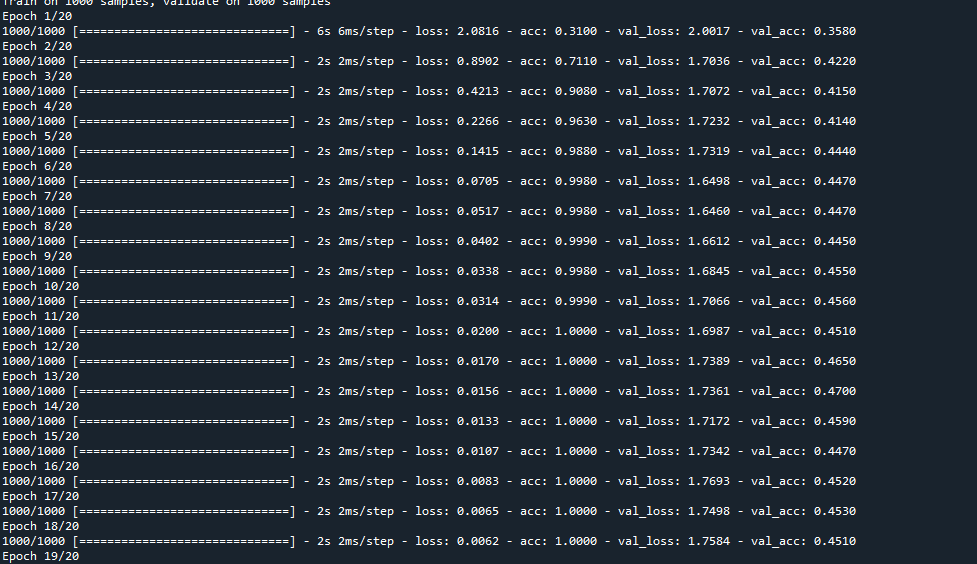

## 예제2(점심시간문제). 위의 설계도에서 conv층도 dropout을 추가하여 오버피팅을 줄여보시오.

In [ ]:
x = Conv2D(filters = 128, kernel_size = 3, strides = 1, padding = 'same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(rate = 0.5)(x)
x = MaxPooling2D(pool_size=2,strides=2)(x)

In [ ]:
import os, cv2, random

# 필요한 라이브러리 import 하는 코드 
import numpy as np

from keras.layers import Input, Flatten, Dense, Conv2D, BatchNormalization, LeakyReLU, Dropout, Activation, MaxPooling2D
from keras.models import Model
from keras.optimizers import Adam
from keras.utils import to_categorical
import keras.backend as K   # 백엔드가  텐서 플로우로 되어있어서 
                                     # 텐서 플로우 명령어 필요할 때 tf 대신에 
                                     # k 를 쓰겠다라는 의미 

from keras.datasets import cifar10

# 데이터 적제 
NUM_CLASSES = 10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()



train_images= x_train 
test_images = x_test 


ROWS= 32
COLS = 32
CHANNELS = 3

def read_image(file_path):
    img = file_path
    return cv2.resize(img, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)

def prep_data(images):
    count = len(images)
    data = np.ndarray((count, ROWS, COLS,CHANNELS), dtype=np.uint8)
    # 4차원 짜리 비어있는 numpy array 생성 

    for i, image_file in enumerate(images):
        image = read_image(image_file)
        data[i] = image       
        if i%250 == 0: print('Processed {} of {}'.format(i, count))
        
    return data

x_train = prep_data(train_images)
x_test = prep_data(test_images)



#  0 ~ 1사이로 정규화 한다. 
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
# 라벨을 10개의 one encoding 생성한다. 
y_train = to_categorical(y_train, NUM_CLASSES)
y_test = to_categorical(y_test, NUM_CLASSES)



# 모델 만들기 
input_layer = Input((32,32,3))

x = Conv2D(filters = 128, kernel_size = 3, strides = 1, padding = 'same')(input_layer)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(rate = 0.5)(x)

x = Conv2D(filters = 128, kernel_size = 3, strides = 1, padding = 'same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(rate = 0.5)(x)
x = MaxPooling2D(pool_size=2,strides=2)(x)


x = Conv2D(filters = 256, kernel_size = 3, strides = 1, padding = 'same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(rate = 0.5)(x)

x = Conv2D(filters = 256, kernel_size = 3, strides = 1, padding = 'same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(rate = 0.5)(x)

x = MaxPooling2D(pool_size=2,strides=2)(x)


x = Conv2D(filters = 512, kernel_size = 3, strides = 1, padding = 'same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(rate = 0.5)(x)

x = Conv2D(filters = 512, kernel_size = 3, strides = 1, padding = 'same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(rate = 0.5)(x)

x = MaxPooling2D(pool_size=2,strides=2)(x)



# 완전 연결 계층 
x = Flatten()(x)

x = Dense(1024)(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(rate = 0.5)(x)

x = Dense(1024)(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(rate = 0.5)(x)

x = Dense(NUM_CLASSES)(x)
output_layer = Activation('softmax')(x)

model = Model(input_layer, output_layer)

# convolution 층 6개, 완전 연결계층 2개 출력층 1개인 9층 신경망 

model.summary()

# 모델 훈련

model_exists = False


if model_exists:
    
    
    model.load_weights('C:\\emp10\\cifar10vgg9.h5')
    
    CLASSES = np.array(['비행기', '자동차', '새', '고양이', '사슴', '개', '개구리', '말',
                                '배', '트럭' ]) 
    preds = model.predict( x_test[1:2] )   
    preds_value = CLASSES[ np.argmax( preds, axis= -1 ) ] 
    actual_value = CLASSES[ np.argmax( y_test [1:2], axis = -1) ] 
    print ( preds_value)
    print ( actual_value)
    
else:
        
    opt = Adam(lr=0.0005)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    model.fit(x_train
              , y_train
              , batch_size=32
              , epochs=100
              , shuffle=True
               , validation_data=(x_test,y_test) )
    
    
    model.save_weights('C:\\emp10\\cifar10vgg9.h5')
    
    model.evaluate(x_test, y_test, batch_size=1000)
    
    CLASSES = np.array(['비행기', '자동차', '새', '고양이', '사슴', '개', '개구리', '말',
                                '배', '트럭' ]) 
    preds = model.predict( x_test[1:2] )   
    preds_value = CLASSES[ np.argmax( preds, axis= -1 ) ] 
    actual_value = CLASSES[ np.argmax( y_test[1:2], axis = -1) ] 
    print ( preds_value)
    print ( actual_value)

## ■ 질병 잎파리와 정상 잎파리 분류 및 신경망 구현

### 1. 질병 잎파리 사진을 확인합니다.

### 2. 이미지 데이터를 숫자로 변환합니다.

### darknamer.exe 프로그램을 이용해서 숫자로 변환합니다.

### darkname 사용법

https://blog.naver.com/PostView.nhn?blogId=kjswoow&logNo=220748596354&categoryNo=161&parentCategoryNo=0&viewDate=&currentPage=1&postListTopCurrentPage=1&from=postView

    -건강한 잎파리 데이터를 1~10000번으로 이름 변경

    -10000중에서 1~9500번까지 train 폴더를 만들어서 넣고

    -9500 ~ 10000번까지 test폴더를 만들어서 넣으시오

    -test 폴더에 번호를 1 ~ 500 으로 변경하고 아래와 같이 되게 하시오~


__건강잎파리__  
train : 1 ~ 9500  
test : 1 ~ 500  

__질병 잎파리__  
train : 9501 ~ 19000  
test : 501 ~ 1000  

## ■ Summary

__훈련 데이터 :__ 

건강 : 1 ~ 9500  
불량 : 9501 ~ 19000  

train 폴더에 1~19000 까지 19000개의 이미지 파일이 들어가야 됨.

__테스트 데이터 :__  

건강 : 1 ~ 500번  
불량 : 501 ~ 1000번  


test 폴더에 1000까지 1000개의 이미지 파일이 들어가야 됨.

## ■ 3. 사진을 전부 32 x  32  사이즈로 일괄 조정합니다.

사진을 resize 한다.

In [ ]:
import  cv2
import  os 
import  numpy  as np

path = "D:\\data9\\train"

file_list = os.listdir(path)
    
for k in file_list:
    img = cv2.imread(path + '\\' + k)
    width, height = img.shape[:2]
    resize_img = cv2.resize(img, (32 , 32), interpolation=cv2.INTER_CUBIC)
    cv2.imwrite('d:\\data9\\train_resize\\' + k, resize_img) 

In [ ]:
import  cv2
import  os 
import  numpy  as np 

path = "D:\\data9\\test"

file_list = os.listdir(path)
    
for k in file_list:
    img = cv2.imread(path + '\\' + k)
    width, height = img.shape[:2]
    resize_img = cv2.resize(img, (32 , 32), interpolation=cv2.INTER_CUBIC)
    cv2.imwrite('d:\\data9\\test_resize\\' + k, resize_img) 

## ■ 4.  훈련 데이터 라벨과  테스트 데이터 라벨을 생성합니다. 


- 훈련 데이터의 라벨                   
  정상이파리(0~9500) :  1              
  질병이파리(9501 ~19000) : 0         


- 테스트 데이터의 라벨  
  정상 이파리(0 ~ 500) : 1  
  질병 이파리(501 ~1000) : 0  

In [4]:
a = []

for i in range(0,5):
    print(i)
    a.append(i)
    
print('\n')
print(a)
print(len(a))

0
1
2
3
4


[0, 1, 2, 3, 4]
5


In [1]:
## *  훈련 데이터 라벨 생성

path = 'd:\\data9\\train_label.csv'
file = open( path, 'w')
for  i  in  range(0, 9500):
    file.write( str(1) + '\n' )
for  i  in  range(0, 9500):
    file.write( str(0) + '\n') 
file.close()

In [ ]:
# * 테스트 데이터 라벨을 생성 하세요 ~

path = 'd:\\data9\\test_label.csv'
file = open( path, 'w')
for  i  in  range(0, 500):
    file.write( str(1) + '\n' )
for  i  in  range(0, 500):
     file.write( str(0) + '\n') 
file.close()

## ■ 5. cifar10 데이터를 신경망에 로드하기 위해 만든 4가지 함수가 있는 loader2.py의 내용을 복사해서 loader3.py로 만든 후에 안의 내용을 이파리 데이터를 로드 할 수 있겠금 수정하시오.

- image_load
- next_batch
- shuffle_batch
- label_load

In [ ]:
# loader3.py 코드

import os
import re
import cv2
import numpy as np
import csv
import random


def image_load(path):
    file_list = os.listdir(path)
    result = []
    file_res = []
    image = []
    
    for i in file_list:
        a = int( re.sub('[^0-9]','',i))
        result.append(a)
    result.sort()
    
    for i in result:
        a = ('%s\\%d.jpg'%(path,i))
        file_res.append(a)
    
    for k in file_res:
        img = cv2.imread(k)        
        image.append(img)
    
    return np.array(image)


def label_load(path):

    file = open(path)
    labeldata = csv.reader(file)
    labellist = list(labeldata)
    label = np.array(labellist)
    label = label.astype(int)
    label = np.eye(2)[label]
    label = label.reshape(-1,2)
    return label


def next_batch( data1, data2, init, fina ):
    return data1[ init : fina ], data2[ init : fina ]

def shuffle_batch( data_list, label ) :
    x = np.arange( len( data_list) )
    random.shuffle(x)
    data_list2 = data_list[x]
    label2 = label[x]
    return data_list2,label2

In [ ]:
import loader3

train_image='d:\\data9\\train_resize\\'
train_label='d:\\data9\\train_label.csv'
test_image='d:\\data9\\test_resize\\'
test_label='d:\\data9\\test_label.csv'

print(loader3.image_load(train_image).shape)
print(loader3.label_load(train_label).shape)
print(loader3.image_load(test_image).shape)
print(loader3.label_load(test_label).shape)

## ■ 6. 잎파리 데이터를 오전에 만든 vgg9 신경망에 넣고 학습 시키겠금 신경망 코드를 수정하세요.

In [ ]:
import os, cv2, random

# 필요한 라이브러리 import 하는 코드 
import numpy as np

from keras.layers import Input, Flatten, Dense, Conv2D, BatchNormalization, LeakyReLU, Dropout, Activation, MaxPooling2D
from keras.models import Model
from keras.optimizers import Adam
from keras.utils import to_categorical
import keras.backend as K   # 백엔드가  텐서 플로우로 되어있어서 
                                     # 텐서 플로우 명령어 필요할 때 tf 대신에 
                                     # k 를 쓰겠다라는 의미 

import loader3

NUM_CLASSES = 2

train_image='d:\\data9\\train_resize\\'
train_label='d:\\data9\\train_label.csv'
test_image='d:\\data9\\test_resize\\'
test_label='d:\\data9\\test_label.csv'

print(loader3.image_load(train_image).shape)
print(loader3.label_load(train_label).shape)
print(loader3.image_load(test_image).shape)
print(loader3.label_load(test_label).shape)

x_train = loader3.image_load(train_image)
y_train = loader3.label_load(train_label)
x_test = loader3.image_load(test_image)
y_test = loader3.label_load(test_label)


# 모델 만들기 
input_layer = Input((32,32,3))

x = Conv2D(filters = 128, kernel_size = 3, strides = 1, padding = 'same')(input_layer)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(rate = 0.5)(x)

x = Conv2D(filters = 128, kernel_size = 3, strides = 1, padding = 'same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(rate = 0.5)(x)
x = MaxPooling2D(pool_size=2,strides=2)(x)


x = Conv2D(filters = 256, kernel_size = 3, strides = 1, padding = 'same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(rate = 0.5)(x)

x = Conv2D(filters = 256, kernel_size = 3, strides = 1, padding = 'same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(rate = 0.5)(x)

x = MaxPooling2D(pool_size=2,strides=2)(x)


x = Conv2D(filters = 512, kernel_size = 3, strides = 1, padding = 'same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(rate = 0.5)(x)

x = Conv2D(filters = 512, kernel_size = 3, strides = 1, padding = 'same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(rate = 0.5)(x)

x = MaxPooling2D(pool_size=2,strides=2)(x)



# 완전 연결 계층 
x = Flatten()(x)

x = Dense(1024)(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(rate = 0.5)(x)

x = Dense(1024)(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(rate = 0.5)(x)

x = Dense(NUM_CLASSES)(x)
output_layer = Activation('softmax')(x)

model = Model(input_layer, output_layer)

# convolution 층 6개, 완전 연결계층 2개 출력층 1개인 9층 신경망 

model.summary()

# 모델 훈련

model_exists = False


if model_exists:
    
    
    model.load_weights('D:\\data9\\leafvgg9.h5')
    
    CLASSES = np.array(['정상', '질병' ]) 
    preds = model.predict( x_test[1:2] )   
    preds_value = CLASSES[ np.argmax( preds, axis= -1 ) ] 
    actual_value = CLASSES[ np.argmax( y_test [1:2], axis = -1) ] 
    print ( preds_value)
    print ( actual_value)
    
else:
        
    opt = Adam(lr=0.0005)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    model.fit(x_train
              , y_train
              , batch_size=32
              , epochs=20
              , shuffle=True
               , validation_data=(x_test,y_test) )
    
    
    model.save_weights('D:\\data9\\leafvgg9.h5')
    
    model.evaluate(x_test, y_test, batch_size=100)
    
    CLASSES = np.array(['정상', '질병' ]) 
    preds = model.predict( x_test[1:2] )   
    preds_value = CLASSES[ np.argmax( preds, axis= -1 ) ] 
    actual_value = CLASSES[ np.argmax( y_test[1:2], axis = -1) ] 
    print ( preds_value)
    print ( actual_value)

## 오늘의 마지막 문제

### 이파리 신경망을 20에폭 이상 수행해서 정확도가 훈련 데이터, 테스트 데이터 모두 95%가 넘는지 확인하고 확인한 모델을 내려서 조원들에게 배포하시오~~

### 카페 게시판에 조별 배포 게시글을 올려서 검사 받을 것